In [101]:
import pandas as pd
import librosa
import numpy as np
import joblib
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [102]:
# Load ground truth annotations from CSV file
ground_truth_path = "../data/csv/en001a.csv"
ground_truth = pd.read_csv(ground_truth_path)

# Load audio file
audio_path = "../data/wav/en001a.wav"
audio_data, sr = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)

In [103]:
# # Define a function to extract features from an audio segment
# def extract_features(audio_path):
#     y, sr = librosa.load(audio_path)
#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
#     return mfccs, sr


In [113]:
# Align MFCC frames with onset and offset times
def align_frames_with_times(mfccs, sr, df, max_length):
    frame_times = librosa.frames_to_time(np.arange(len(mfccs.T)), sr=sr)
    aligned_features = []
    aligned_labels = []

    for idx, row in df.iterrows():
        onset_frame = np.argmax(frame_times >= row['start'])
        offset_frame = np.argmax(frame_times >= row['end'])
        feature_sequence = mfccs[:, onset_frame:offset_frame]

        # Pad or truncate feature sequence to the fixed length
        if feature_sequence.shape[1] < max_length:
            pad_width = max_length - feature_sequence.shape[1]
            padded_sequence = np.pad(feature_sequence, ((0, 0), (0, pad_width)), mode='constant')
            aligned_features.append(padded_sequence)
        else:
            truncated_sequence = feature_sequence[:, :max_length]
            aligned_features.append(truncated_sequence)

        aligned_labels.append(row['pitch'])

    # Convert aligned_features to a numpy array
    aligned_features = np.array(aligned_features)

    # Mask the padding values
    mask = (aligned_features.sum(axis=-1) != 0).astype(np.float32)[:, :, np.newaxis]
    masked_features = aligned_features * mask
    return masked_features, aligned_labels


In [115]:
# Align MFCC frames with onset and offset times
# max_frames = 100  # Example: Set a fixed length for MFCC frames
aligned_features, aligned_labels = align_frames_with_times(mfccs, sr, ground_truth, 100)


# Convert aligned_features to numpy array
# X = np.array(aligned_features)
X = aligned_features

# Convert aligned_labels to numpy array
y = np.array(aligned_labels)

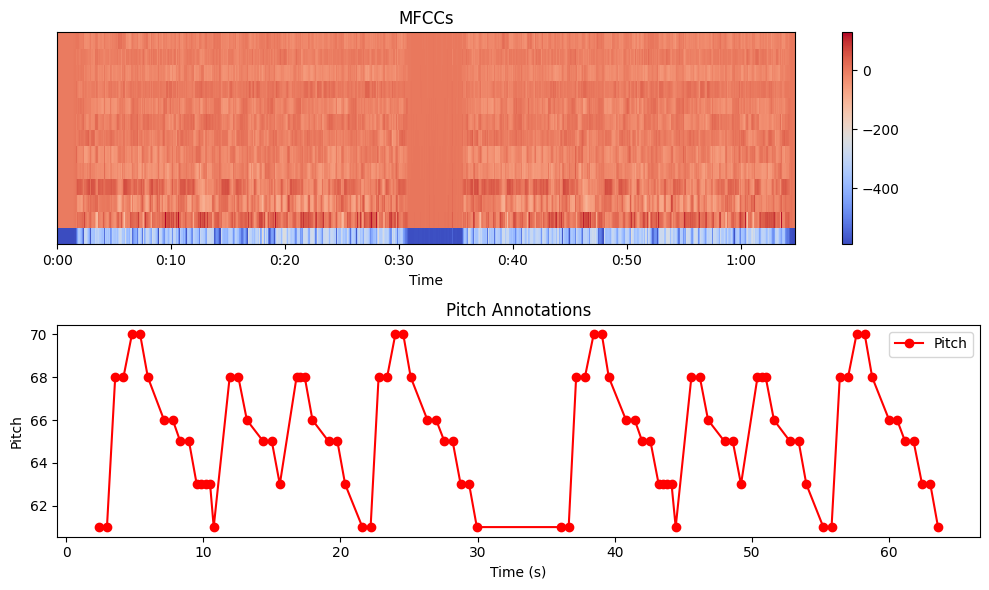

In [116]:
# Visualize MFCCs with pitch annotations
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')

plt.subplot(2, 1, 2)
plt.plot(ground_truth['start'], ground_truth['pitch'], 'ro-', label='Pitch')
plt.xlabel('Time (s)')
plt.ylabel('Pitch')
plt.title('Pitch Annotations')
plt.legend()

plt.tight_layout()
plt.show()

In [118]:
X.shape

(86, 13, 100)

In [119]:
# # Extract features according to ground truth annotations
# features = []
# pitch_values = []
# for _, row in ground_truth.iterrows():
#     onset, offset, pitch = row['start'], row['end'], row['pitch']
#     segment_features = extract_features(audio_data, onset, offset)
#     features.append(segment_features)
#     pitch_values.extend([pitch] * segment_features.shape[0])

# # Convert features and pitch_values to numpy arrays
# features = np.vstack(features)
# pitch_values = np.array(pitch_values)


In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional, BatchNormalization
from tensorflow.keras.models import save_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adadelta


In [121]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
s_scaler = StandardScaler()
X_train_scaled = s_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = s_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Reshape y_train to 2D array for fitting the scaler
y_train_reshaped = y_train.reshape(-1, 1)

# Fit the MinMaxScaler on the y_train_reshaped
scaler = MinMaxScaler(feature_range=(0, 127)) # MIDI notes range from 0 to 127
scaler.fit(y_train_reshaped)

# Reshape features for LSTM input (assuming LSTM expects input shape of (n_samples, n_timesteps, n_features))
# X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
# X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

X_train_reshaped = X_train_scaled
X_test_reshaped = X_test_scaled

In [122]:
X_train_reshaped.shape

(68, 13, 100)

In [147]:
# Define the LSTM model
model = Sequential([
    Bidirectional(LSTM(128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True)),
    # LSTM(128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
    # LSTM(128, input_shape=(X_train_reshaped.shape[1], ), return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='tanh'),
    Dense(1)  # Output layer for pitch prediction
])
# Adadelta optimizer
# optimizer = Adadelta(learning_rate=1.0)
# Compile the model
# model.compile(optimizer=optimizer, loss='mse')
model.compile(optimizer='SGD', loss='mse')

# Train the model
model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=35, batch_size=5)

Epoch 1/35
14/14 [==============================] - 8s 130ms/step - loss: 799.6076 - val_loss: 7.5681
Epoch 2/35
14/14 [==============================] - 0s 21ms/step - loss: 26.5847 - val_loss: 10.5446
Epoch 3/35
14/14 [==============================] - 0s 24ms/step - loss: 37.9741 - val_loss: 97.2861
Epoch 4/35
14/14 [==============================] - 0s 26ms/step - loss: 78.8020 - val_loss: 7.3668
Epoch 5/35
14/14 [==============================] - 0s 27ms/step - loss: 12.1538 - val_loss: 25.4426
Epoch 6/35
14/14 [==============================] - 0s 26ms/step - loss: 45.1234 - val_loss: 7.5676
Epoch 7/35
14/14 [==============================] - 1s 43ms/step - loss: 13.9355 - val_loss: 64.1338
Epoch 8/35
14/14 [==============================] - 1s 47ms/step - loss: 13.0151 - val_loss: 8.4947
Epoch 9/35
14/14 [==============================] - 1s 44ms/step - loss: 15.7422 - val_loss: 7.4217
Epoch 10/35
14/14 [==============================] - 0s 36ms/step - loss: 16.7990 - val_loss: 

In [148]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred = model.predict(X_test_reshaped).flatten()
y_pred = [int(i) for i in y_pred]

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


1/1 [==============================] - 1s 1s/step
Mean Squared Error: 2.4444444444444446
Mean Absolute Error: 1.2222222222222223


In [149]:
print(y_pred)
print(y_test)

[70, 64, 67, 67, 64, 65, 65, 68, 70, 69, 68, 64, 66, 64, 66, 68, 70, 68]
[68 61 65 68 63 63 65 66 70 68 66 63 65 61 65 68 70 68]


In [150]:
# Save the model
save_model(model, 'model.h5')

In [151]:
joblib.dump(s_scaler, 'scaler.pkl')

['scaler.pkl']